# Treating depth recovery as the reconstruction of the direct-only epipolar block $\mathbf T$ of the transport matrix

In the following, we assume a 1D projection pattern $\mathbf{p}$ and 1D image $\mathbf{c}$,
associated with corresponding epipolar lines in the projector and
camera image planes, respectively. 

We'll also focus on the case of a scene that is a fronto-parallel plane,
ie. all image pixels have the same stereo disparity. Generalization to
other plane orientations is straightforward.

## Python libraries

In [10]:
import numpy as np
import scipy.linalg as spl
import scipy.fftpack as fp
import matplotlib.pyplot as plt

%matplotlib inline

## Basic parameters

In [11]:
projector_pixels = 500
projector_blur_sigma = 1
camera_pixels = 400
camera_blur_sigma = 1
disparity = 6
pattern_frequency = 40
pattern_phase = 0
window = np.array([200,250])

max_disparity = projector_pixels/(2.0*pattern_frequency)
if np.abs(disparity) > (projector_pixels/(2.0*pattern_frequency)):
    print '''
Warning: disparity will be wrapped -- use value in the range [%g,%g]
'''%(-max_disparity,max_disparity)
    

## Initialization & helper functions

image plotting function

In [12]:
def image(im,cmap='gray'):
    plt.figure(figsize=(10,10), dpi=100)
    plt.imshow(im,cmap,aspect='equal')

function for creating a defocus kernel of a given $\sigma$, size and shape
with its center as the first element

In [13]:
def defocusKernel(sigma=1, size=None, function='gaussian'):
    if function == 'gaussian':
        if sigma == 0:
            kernel = np.array([1.0,0])
            shift = 0
        else:
            maxx = np.int(np.ceil(3*sigma))
            x = np.array(range(-maxx,maxx,1))
            kernel = np.zeros(len(x))
            kernel = np.exp(-x*x*1.0/(2*sigma*sigma))
            shift = -maxx
    elif function == 'pillbox':
        maxx = np.int(np.ceil(2*sigma))
        x = np.array(range(-maxx,maxx,1))
        kernel = np.zeros(len(x))
        kernel = np.absolute(x)
        kernel = map(lambda y: (abs(y)<=sigma)*1.0, x)
        shift = -maxx
        
    if size is None:
        return np.roll(kernel,shift) / np.sum(kernel)
    else:
        kernel2 = np.zeros(size)
        if (size >= len(kernel)):
            kernel2[0:len(kernel)] = kernel
        else:
            kernel2 = kernel[0:size]
        return np.roll(kernel2,shift) / np.sum(kernel2)

function for creating projection patterns

In [14]:
def pattern(size, freq=None, phase=None, function='cosine'):
    if (freq is None) or (freq >= np.floor(size/2)):
        freq = np.int(np.floor(size/2))
    else:
        freq = np.int(np.floor(freq))
    if phase is None:
        phase = 0

    if function == 'cosine':
        f = np.zeros(size,dtype=complex)
        f[freq] = np.complex(np.cos(phase),np.sin(phase))
        # create a cosine for the specified frequency
        p = np.real(fp.ifft(f))
        # make sure its elements are all positive
        p = p + np.max(p)
        return p
    
    if function == 'noise':
        # generate a random phase map
        rphase = np.random.uniform(0,1,size)*np.pi
        # generate a flat spectrum up to a specified frequency
        rspec = np.zeros(size)
        rspec[0:freq] = 1
        # build its Fourier transform
        f = rspec * np.exp(1j*rphase)
        # compute the inverse
        p = np.real(fp.ifft(f))
        p = p + np.max(p)
        return p        

function for converting phases to disparities

In [15]:
def phase2disparity(phases, frequencies, T):
    image_pattern_periods = T.shape[1]*1.0/frequencies
    disparities = image_pattern_periods * phases/(2*np.pi)
    return disparities

Function for creating a probing matrix containing $k$ interleaved projection patterns.

The patterns are specified as a list $[~(\omega_1,\phi_1,\text{function}_1),\ldots,(\omega_k,\phi_k,\text{function}_k)~]$.

In [16]:
def probing(shape, patterns=None):
    if not (patterns is None):
        probe_matrix = np.zeros(shape,float)
        i = 0
        for freq, phase, function in patterns:
            pat = pattern(shape[1], freq, phase, function)
            indices = len(range(i,shape[0],len(patterns)))
            probe_matrix[i:shape[0]:len(patterns),:] = np.ones((indices,1)).dot(pat.reshape(1,len(pat)))
            i += 1
        return probe_matrix

# A: Conventionally-projected single-frequency patterns

## A.1. Create a transport matrix corresponding to a plane at a fixed depth (ie. disparity = constant) 

Observe that a non-fronto-parallel plane would simply correspond to a line of a different orientation in $\mathbf{T}$.


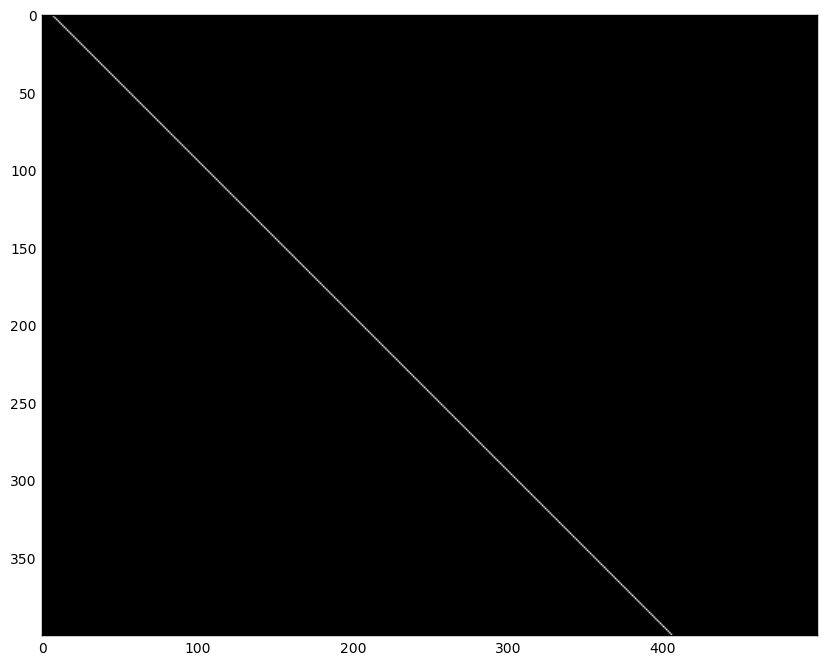

In [17]:
a = np.eye(camera_pixels,M=projector_pixels)
T = np.roll(a,np.int(np.floor(disparity)),axis=1)
image(T)

## A.2. Define a blur kernel for projector defocus

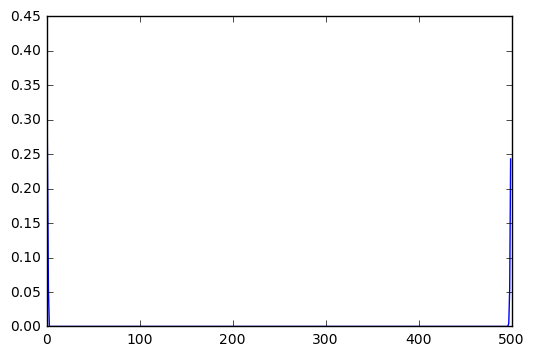

In [18]:
projector_kernel = defocusKernel(sigma=projector_blur_sigma,size=projector_pixels,function='gaussian')
plt.plot(projector_kernel)

## A.3. Construct the Toeplit matrix $\mathbf{P}$ corresponding to projector blur

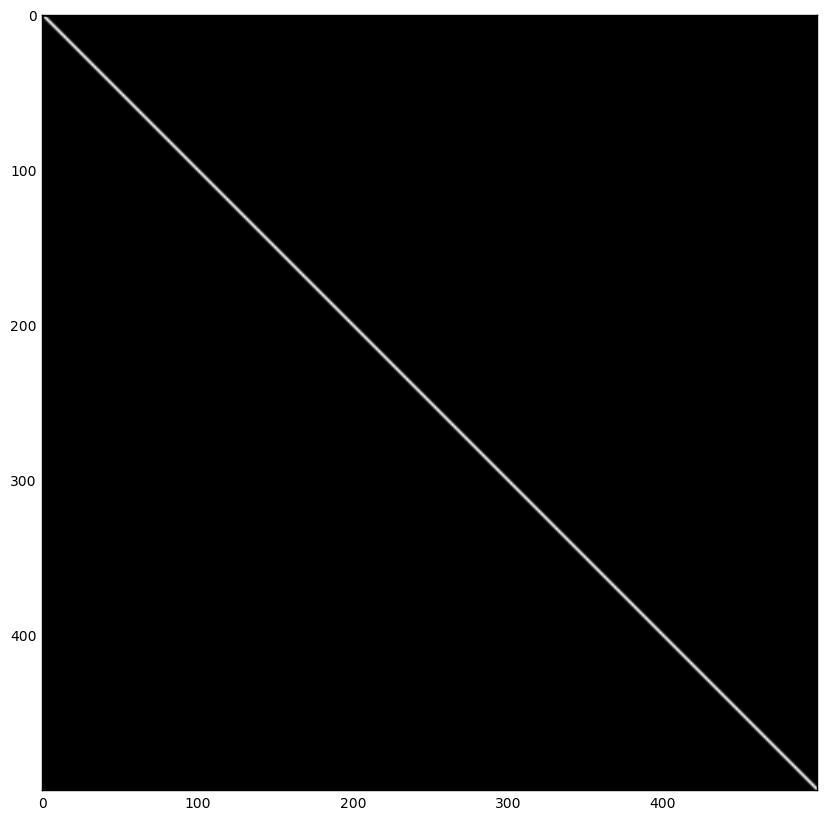

In [19]:
P = spl.toeplitz(projector_kernel)
image(P)

## A.4. Define a blur kernel for camera defocus

(I deliberately chose a much wider blur kernel for the camera).

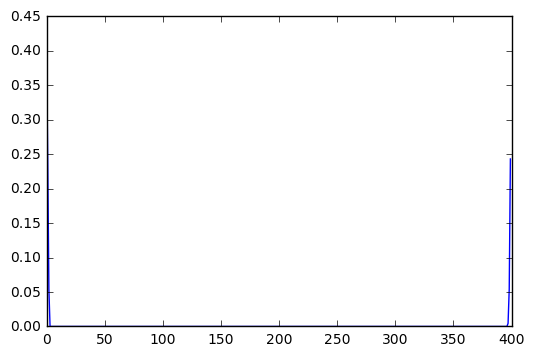

In [20]:
camera_kernel = defocusKernel(sigma=camera_blur_sigma,size=camera_pixels,function='gaussian')
plt.plot(camera_kernel)

## A.5. Construct the Toeplit matrix $\mathbf{C}$ corresponding to camera blur

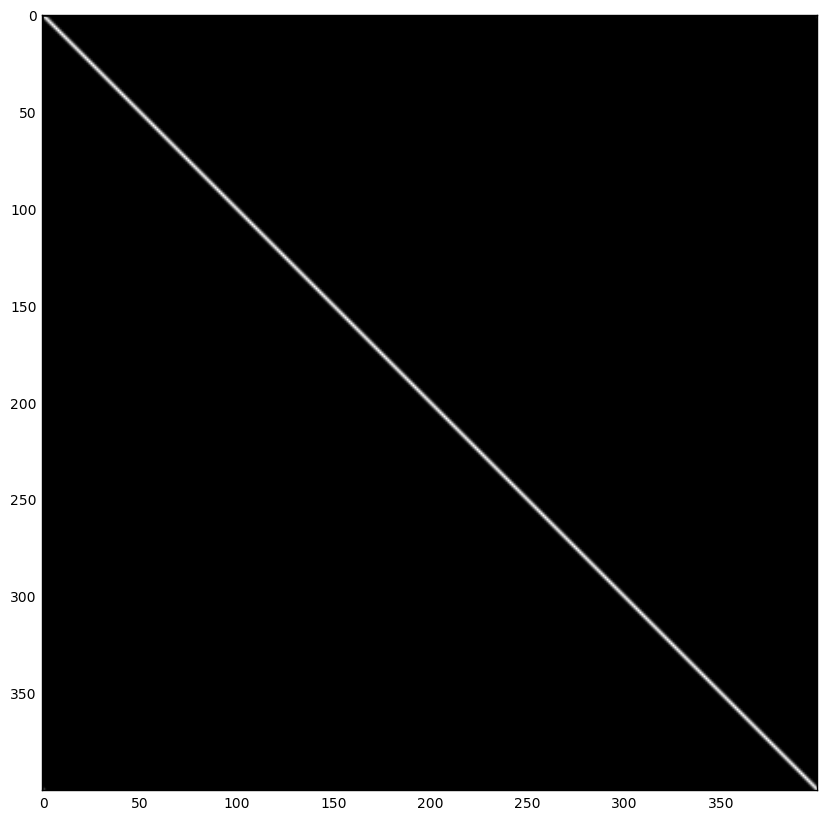

In [21]:
C = spl.toeplitz(camera_kernel)
image(C)


## A.6. Construct the combined transport matrix $\mathbf{C T P}$

This is still a Toeplitz matrix



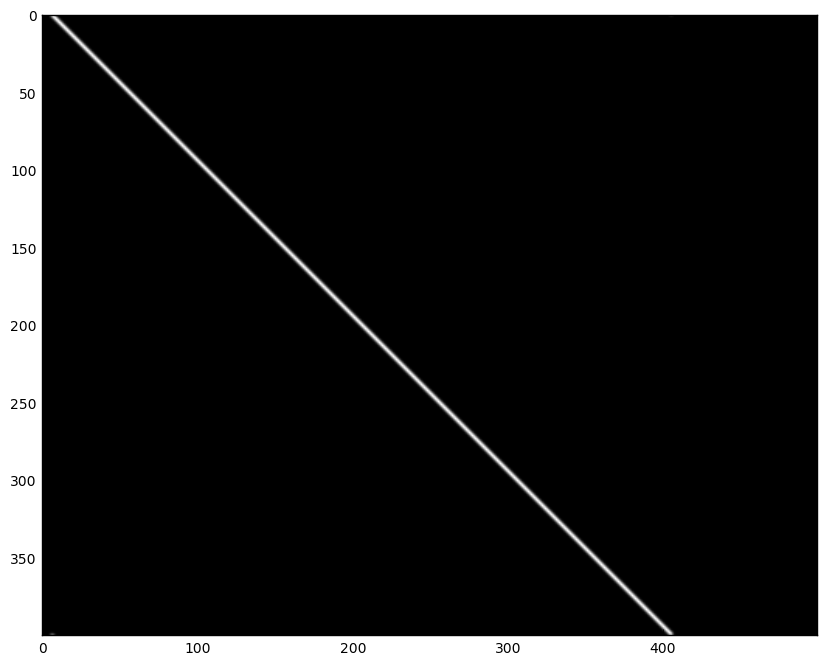

In [22]:
CTP = C.dot(T.dot(P))
image(CTP)

## A.7. The Fourier Transform $\mathcal{F}[\mathbf{T}]$

Since $\mathbf{T}$ is constant along a specific direction in the spatial domain,
the non-zero elements of its Fourier Transform *must* lie along a single
line on the 2D frequency plane.

In [23]:
fT = fp.fft2(T)


Here is the spectrum:

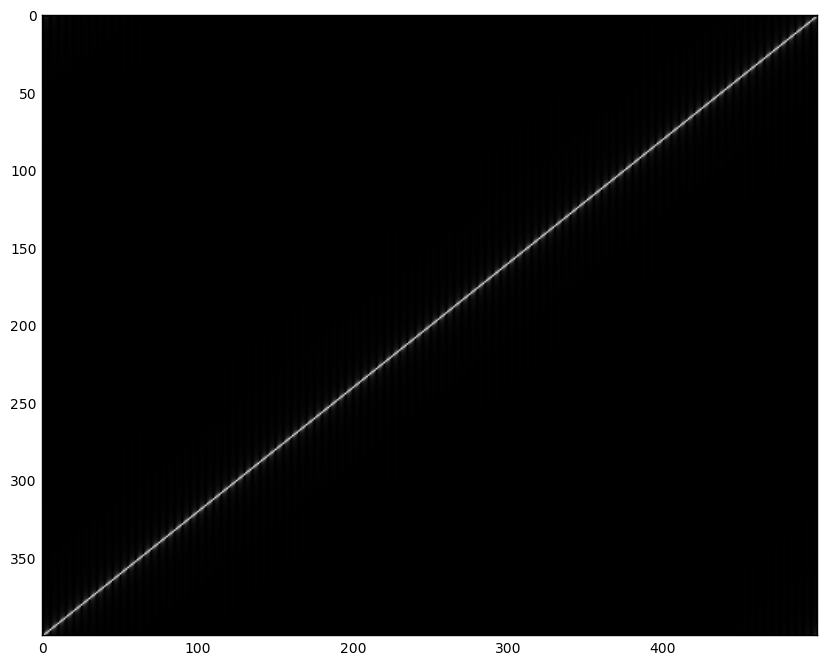

In [24]:
image(fp.fftshift(np.abs(fT)))

## A.8. The Fourier Transform $\mathcal{F}[\mathbf{C T P}]$

As we saw above, matrix $\mathbf{C T P}$ is *not* constant along a specific direction on the 2D plane. As a result, its Fourier Transform is *not* concentrated along a single line anymore. Rather, the line associated with the support of $\cal{F}[\mathbf{T}]$ is "blurred" to some extent.

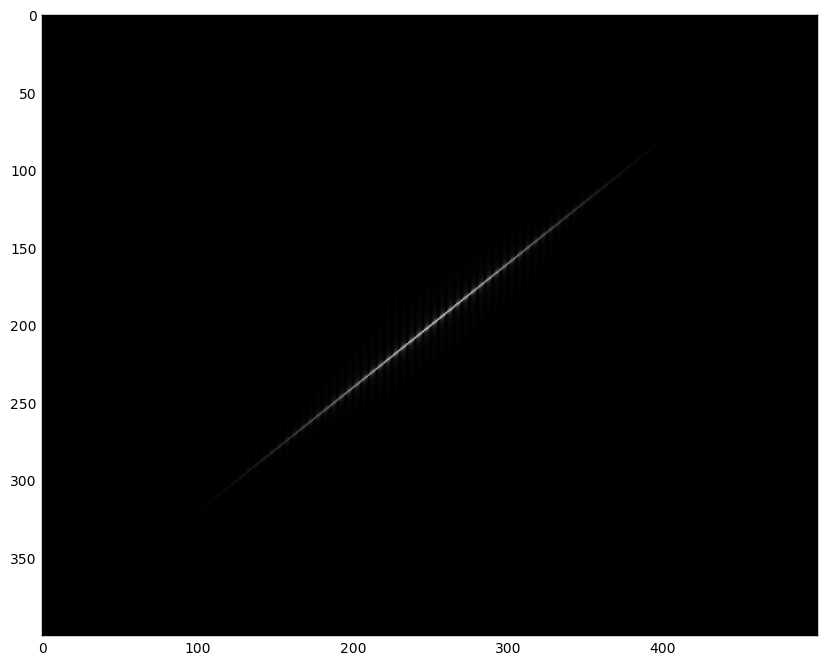

In [25]:
fCTP = fp.fft2(CTP)
image(fp.fftshift(np.abs(fCTP)))

## A.9. Recovering the depth of an image patch

We want to compute per-pixel depth, not a single depth plane for the whole image.
This corresponds to considering just a small window $\mathbf{w}$ around a given camera pixel.


This can be expressed as a crop of the matrix $\mathbf{CTP}$, so that it is non-zero
only in a small image window. We compute the matrix $\mathbf{W}$, of the same size as $\mathbf{T}$, which we can multiply elementwise with $\mathbf{T}$ to do this crop.



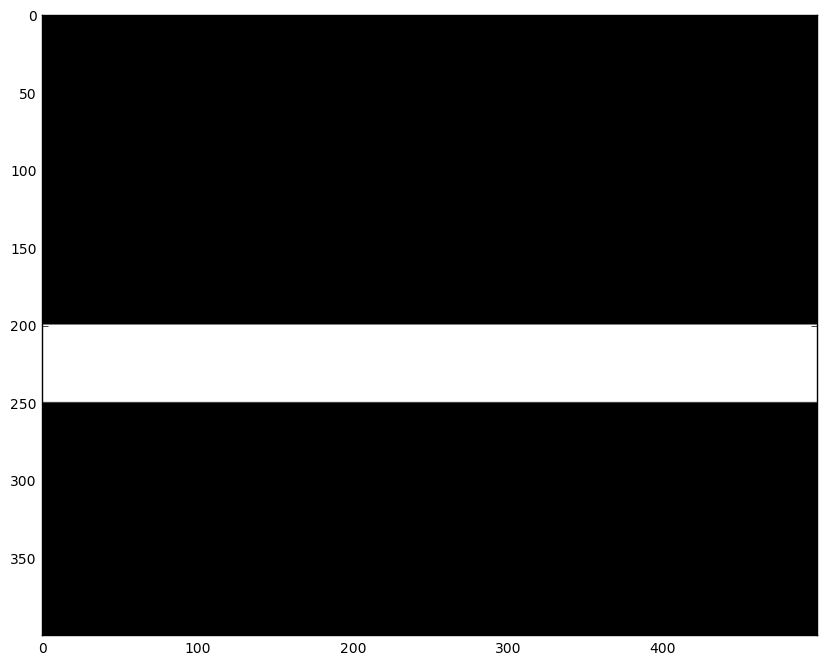

In [26]:
w = np.zeros(T.shape[0])
w[window[0]:window[1]] = 1
# let us now form the full matrix that will do the crop
W = np.reshape(w,(T.shape[0],1)).dot(np.ones((1,T.shape[1])))
image(W)




## A.10. The Fourier Transform $\mathcal{F}[\mathbf{W}]$

Note that its non-zero elements are concentrated on a vertical line in frequency space. Again, this is because the elements of the above "image" are constant along a particular direction---in this case the horizontal direction (i.e., the rows).

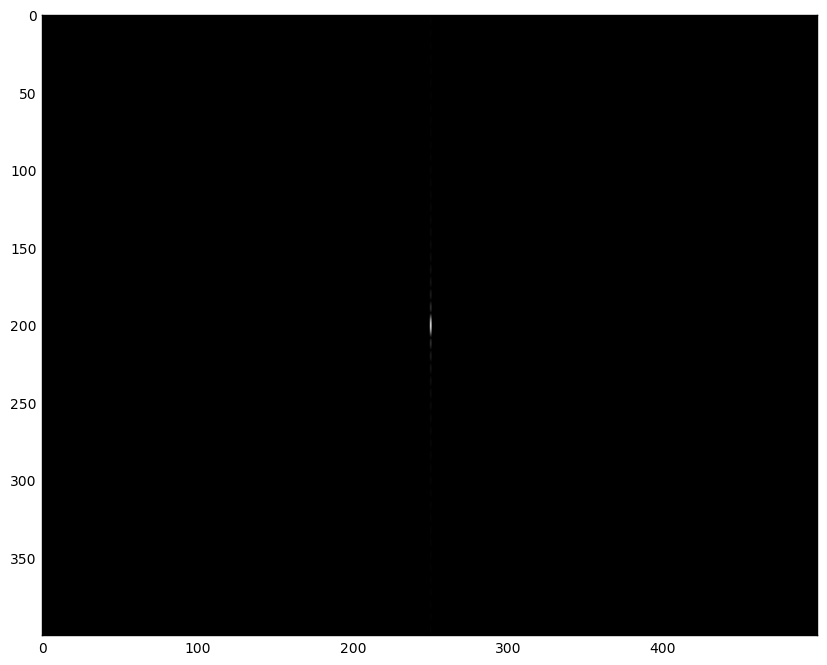

In [27]:
fW = fp.fft2(W)
image(fp.fftshift(np.abs(fW)))

## A.11. The "Cropped" transport matrix, $\mathbf{W} \odot \mathbf{C T P}$

This matrix is the "best" we can hope to reconstruct about the depth of scene
points projecting to that image window.

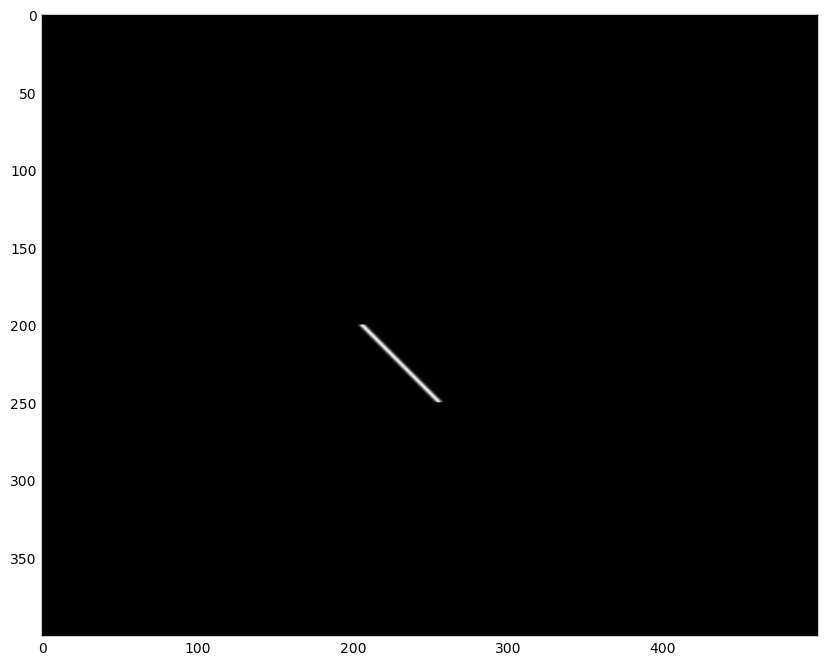

In [28]:
WCTP = W * CTP
image(WCTP)

## A.12. The Fourier Transform, $\mathcal{F}[\mathbf{W} \odot \mathbf{C T P}]$

This is given by the convolution of $\mathcal{F}[\mathbf{C T P}]$ and $\mathcal{F}[\mathbf{W}]$.

**Remarks:** 
* This transform establishes an upper bound on the frequency content of the resulting depth map, as well as a bound on its spatial resolution on the image plane, *i.e.*, no matter what patterns we project onto the scene and no matter how many of them we have, we will *not* be able to reconstruct the zeroed-out frequencies of the transport matrix.
* In the case of a scene plane with a non-fronto-parallel orientation, the "blurry blobs" in the fourier transform would simply be oriented differently (as long as
blur is assumed to not vary spatially).

**To do:** Work out precisely what these bounds are, as a function of
* the camera & projector resolutions
* the camera & projector blur kernels
* the slant of the scene plane (ok to stick to fronto-parallel planes for the time being).

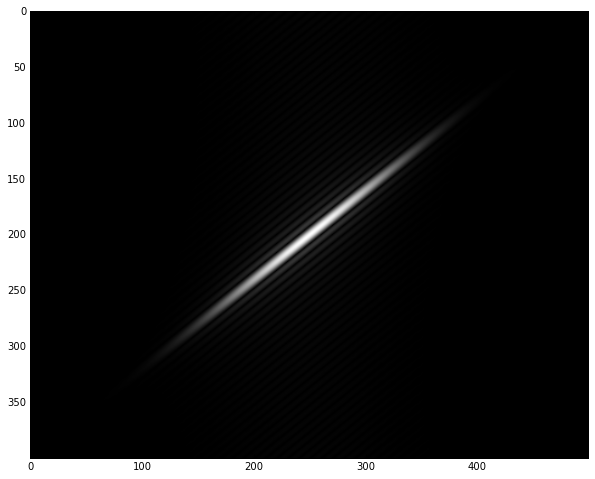

In [22]:
fWCTP = fp.fft2(WCTP)
image(fp.fftshift(np.abs(fWCTP)))



## A.13. The projection pattern $\mathbf{q}$

But we don't have "direct access" to the above image; all we can do
is project a pattern and observe the intensities in the chosen window.

Here we consider a projection pattern $\mathbf{q}$ that is a cosine of a chosen frequency $\omega$ and phase.

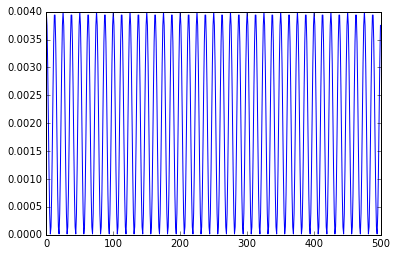

In [23]:
q = pattern(projector_pixels,phase=pattern_phase,freq=pattern_frequency)
plt.plot(q)

## A.14. The probing matrix $\mathbf{Q}$ of the projection pattern

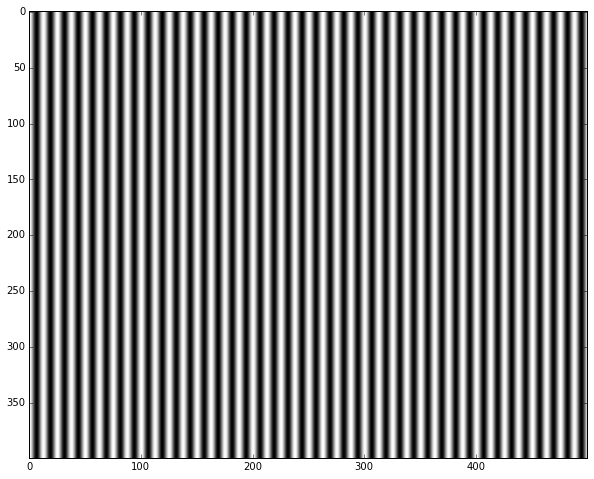

In [51]:
Q = np.ones((T.shape[0],1)).dot(np.reshape(q,(1,len(q))))
image(Q)

## A.15. The complete product, $\mathbf{Q \odot (W \odot C T P)}$

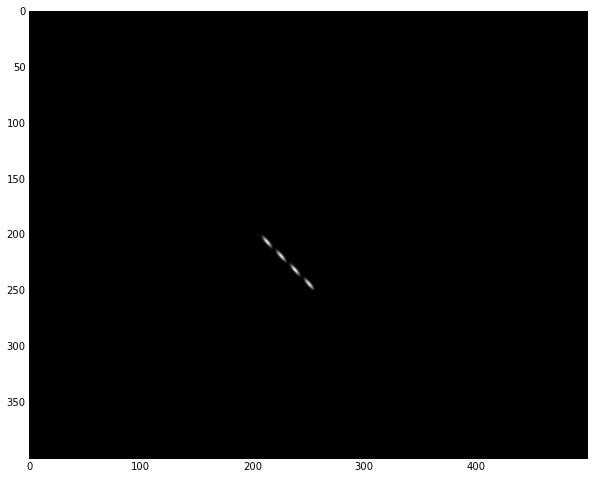

In [52]:
QWCTP = Q*WCTP
image(QWCTP)


## A.16. The Fourier Transform $\mathcal{F}[\mathbf{Q}]$

This is non-zero at exactly 3 frequencies: at the DC frequency (because the pattern has
a non-zero mean) and at frequencies $(\pm \omega, 0)$



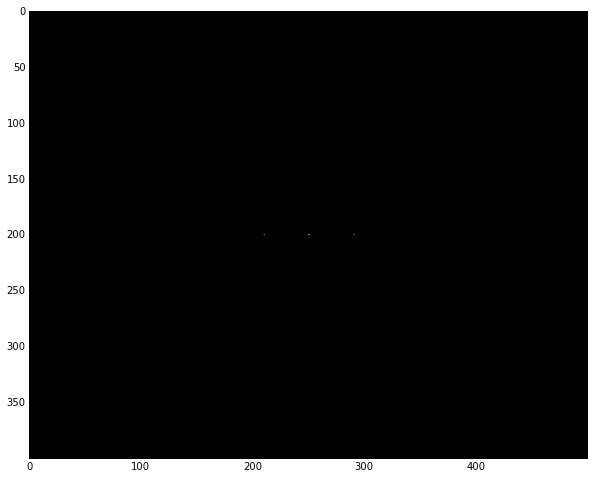

In [53]:
fQ = fp.fft2(Q)
image(fp.fftshift(np.abs(fQ)))

## A.17. The Fourier Transform of the complete product, $\mathcal{F}[\mathbf{Q \odot (W \odot C T P)}]$

This is equal to the 2D convolution of $\mathcal{F}[\mathbf{Q}]$ and $\mathcal{F}[\mathbf{W \odot C T P}]$.

Since $\mathcal{F}[\mathbf{Q}]$ has exactly 3 non-zero elements, the result is a sum of 3 copies of $\mathcal{F}[\mathbf{W \odot C T P}]$. Therefore, the frequency of the pattern controls the distance between these copies (and whether or not they overlap to cause aliasing).



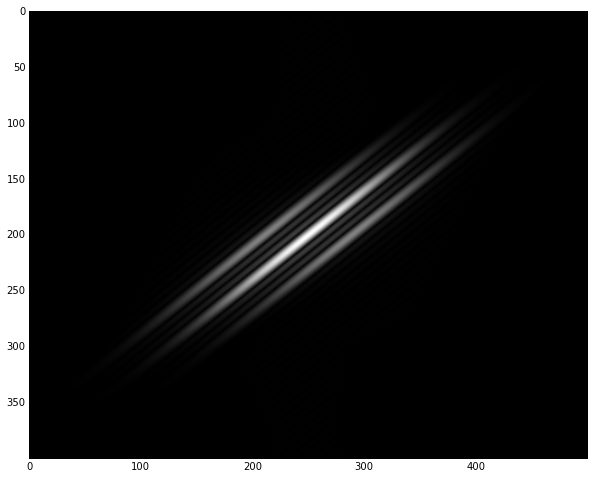

In [54]:
fQWCTP = fp.fft2(QWCTP)
image(fp.fftshift(np.abs(fQWCTP)))

## A.18. The final image (within the chosen window)

This image is equal to $\mathbf{Q \odot (W \odot C T P)~1}$, where $\mathbf{1}$ is a column vector of all ones.

We can compute it by summing the rows of $\mathbf{Q \odot (W \odot C T P)}$.

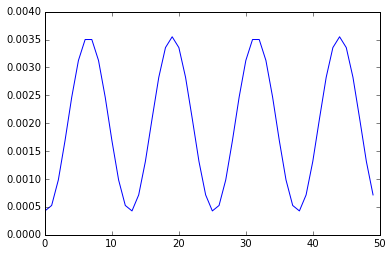

In [55]:
c = np.sum(QWCTP,axis=1)
plt.plot(c[window[0]:window[1]])

## A.19. The Fourier Transform of the final image

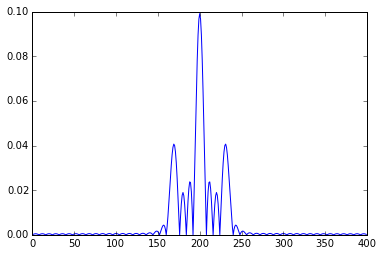

In [56]:
fc = fp.fft(c)
plt.plot(fp.fftshift(np.abs(fc)))

## A.20. The Fourier Tranform of the final image (method #2)

According to the Fourier Slice Theorem, this image is nothing other 
than the vertical slice of $\mathbf{Q \odot (W \odot C T P)}$.

Let's verify this, as a sanity check:

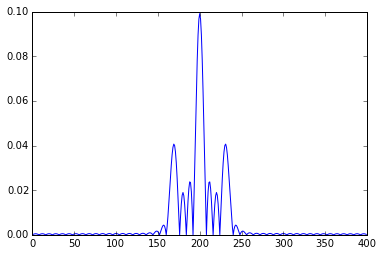

In [57]:
plt.plot(fp.fftshift(np.abs(fQWCTP[:,0])))

In [58]:
image_pattern_frequency = pattern_frequency*camera_pixels/projector_pixels
image_pattern_period = projector_pixels*1.0/pattern_frequency
depth_coeff = fc[image_pattern_frequency]
computed_disparity = phase2disparity(np.angle(depth_coeff),pattern_frequency, T)
print 'true disparity = %g,  computed disparity = %g'%(disparity, computed_disparity),\


true disparity = 6,  computed disparity = 6


# Case B: Probing matrices consisting of $k$ interleaved single-frequency patterns

## B.1. Construct the probing matrix $\mathbf{Q}_1$

We use three interleaved cosine patterns of the same frequency, with each pattern phase-shifted by $3\pi/2$ relative to the previous one.

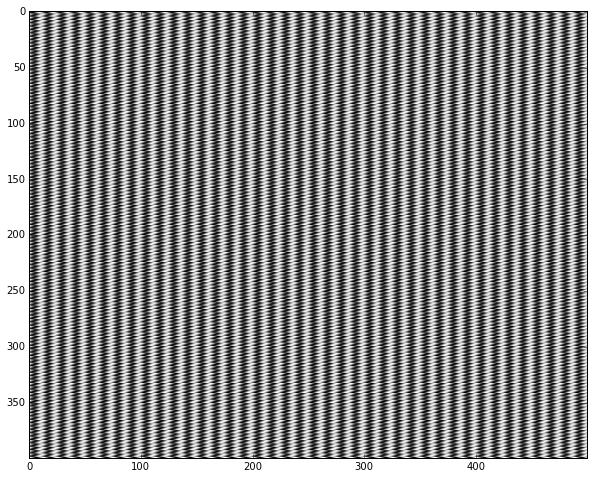

In [59]:
patterns = [(pattern_frequency,pattern_phase,'cosine'),\
            (pattern_frequency,pattern_phase + np.pi/3,'cosine'),\
            (pattern_frequency,pattern_phase + 2*np.pi/3,'cosine'),\
            ]
Q1 = probing(T.shape, patterns)
image(Q1)

## B.2. The Fourier Transform $\mathcal{F}[\mathbf{Q}_1]$

*Note:* In the image below, I did not apply *fftshift()* so that the highest-frequency elements of the fourier transform are in the center of the image (and thus easier to see)

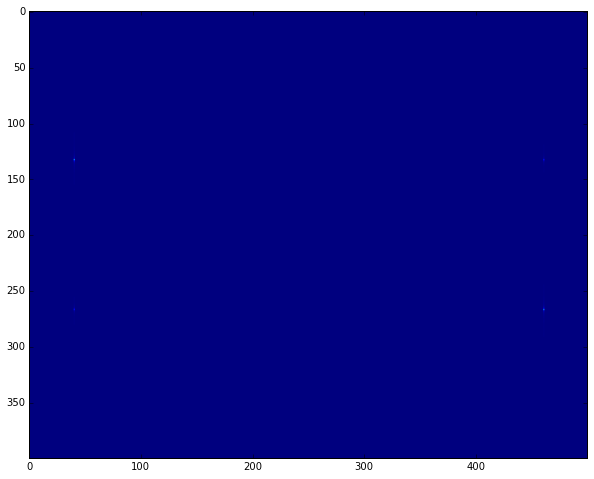

In [60]:
fQ1 = fp.fft2(Q1)
image(np.abs(fQ1),cmap='jet')

## B.3 The Fourier Transform of the complete product $\mathcal{F}[\mathbf{Q_1 \odot (W \odot C T P)}]$

Here we can observe the key difference between conventionally-projected patterns and probing matrices generated by interleaved patterns:

* In the case of a conventionally-projected pattern (see A.17 above), we get three copies of the Fourier tranform $\mathcal{F}[W \odot C T P]$: the original one at the DC frequency $(0,0)$, one centered at $(0,-\omega)$ and one centered at $(0,\omega)$. This causes problems for small windows because of aliasing, which destroys the phases when the three copies overlap.
* When we use a $k$-pattern probing matrix, however, we get **$2k$ more** copies. 
* Because these copies are much farther apart, the possibility of aliasing is reduced significantly.

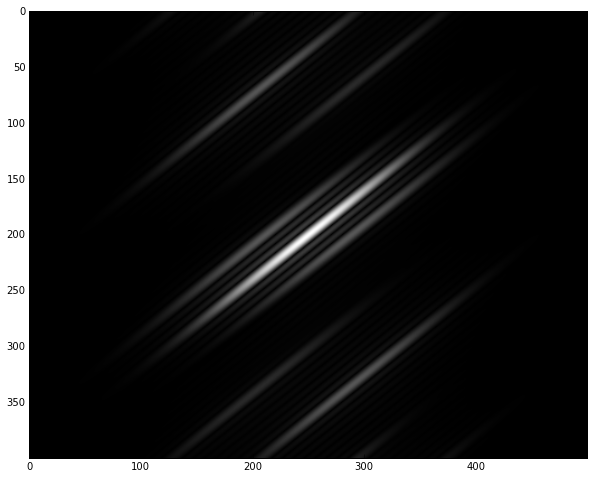

In [61]:
Q1WCTP = Q1*WCTP
fQ1WCTP = fp.fft2(Q1WCTP)
image(fp.fftshift(np.abs(fQ1WCTP)))


## B.4. The Fourier Transform of the final photo: $\mathcal{F}[\mathbf{Q_1 \odot (W \odot C T P) ~1}]$

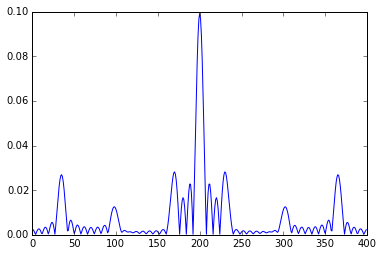

In [62]:
fc1 = fQ1WCTP[:,0]
plt.plot(fp.fftshift(np.abs(fc1)))

## B.5. The final photo (within the crop window)

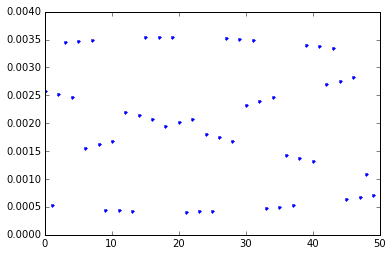

In [63]:
plt.plot(np.abs(fp.ifft(fc1))[window[0]:window[1]],'.')